In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from tqdm.auto import trange, tqdm

DEVICE = 'cuda'

torch.__version__, torch.cuda.is_available()

('1.3.1', True)

60000

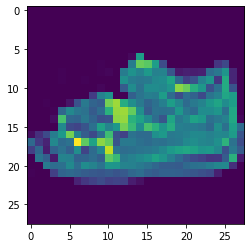

In [149]:
dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[0])
    ]),
    download=True
)

mk_data_loader = lambda bs: torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=bs,
    shuffle=True
)

dl = mk_data_loader(12)
X, y = next(iter(dl))
X.shape

plt.imshow(X[0])
len(dataset)

In [150]:
def bce(pred, target):
    return -pred * torch.log(target) - (1 - pred) * torch.log(1 - target)

In [151]:
class VAE(nn.Module):
    def __init__(self, input_shape, encoding_size):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        flatten_size = np.prod(list(input_shape))
        encoding_size = encoding_size

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 512),
            nn.ReLU(),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.ReLU(),
#             nn.BatchNorm1d(512),
            nn.Linear(512, encoding_size * 2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 512),
            nn.ReLU(),
#             nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.ReLU(),
#             nn.BatchNorm1d(512),
            nn.Linear(512, flatten_size),
            nn.Sigmoid(),
        )
        
        self.loss = nn.BCELoss(reduction='none')
        
    def criterion(self, x):
        mu, log_sig = vae.encode(x)
        s = vae.sample(mu, log_sig)
        y = vae.decode(s)

        recon = self.loss(y, x)
        recon = torch.sum(recon.reshape(recon.size(0), -1), dim=1)
        kl = 0.5 * torch.sum(torch.exp(log_sig) + mu ** 2.0 - 1.0 - log_sig, dim=1)
        
        return (recon + kl).mean()
        
    def decode(self, x):
        o = self.decoder(x)
        return o.reshape(*[-1, *self.input_shape])

    def encode(self, x):
        o = self.encoder(x)
        mu, log_sig = torch.chunk(o, 2, dim=1)
        return mu, log_sig
    
    def sample(self, mu, log_sig):
        s = torch.normal(0, 1, mu.shape).to(DEVICE)
        return mu + s * torch.exp(log_sig / 2)
    
    def forward(self, x):
        mu, log_sig = vae.encode(x)
        s = vae.sample(mu, log_sig)
        out = vae.decode(s)
        return out

In [152]:
emb_size = 2
vae = VAE(X[0].shape, emb_size).to(DEVICE)
inp = torch.rand(X.shape).to(DEVICE)
out = vae.criterion(inp)
out

tensor(544.3239, device='cuda:0', grad_fn=<MeanBackward0>)

In [153]:
def optimize(model, data, epochs, lr=0.01, on_it=lambda _: None):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    tr = trange(epochs)
    for epoch in tr:
        for i, (X, y) in tqdm(
            enumerate(data),
            total=len(data),
            desc='Epoch [%i/%i]' % (epoch + 1, epochs)
        ):
            X = X.to(DEVICE)
            optimizer.zero_grad()
            loss = model.criterion(X)

            loss.backward()
            optimizer.step()

            l = loss.item()
            tr.set_description('Loss %.6f' % l)
            tr.refresh() 
            on_it(i)

        fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
        X_rec = vae(X.to(DEVICE))

        axs[0].imshow(X[0].cpu().numpy())
        axs[1].imshow(X_rec[0].cpu().detach().numpy())
        plt.show()

        history.append(l)
    
    return history

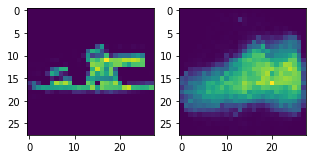

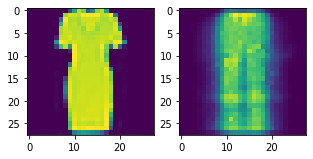

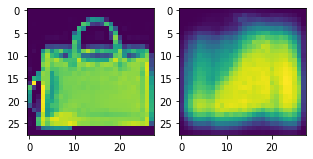

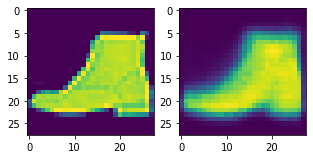

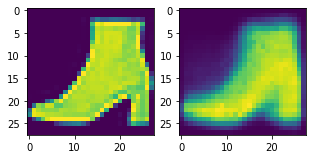

In [154]:
loader = mk_data_loader(bs=1024)
history = optimize(
    model=vae,
    data=loader,
    epochs=5,
    lr=0.01
)

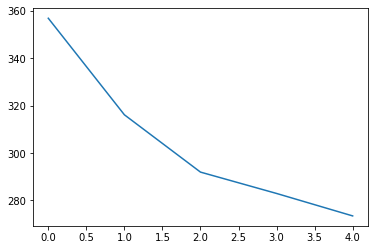

In [155]:
plt.plot(history)

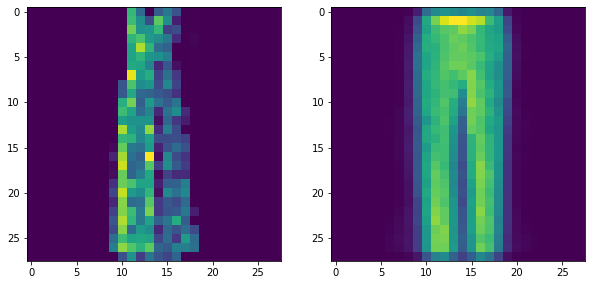

In [156]:
X = next(iter(loader))[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
X_rec = vae(X.to(DEVICE))

axs[0].imshow(X[0])
axs[1].imshow(X_rec[0].cpu().detach().numpy())

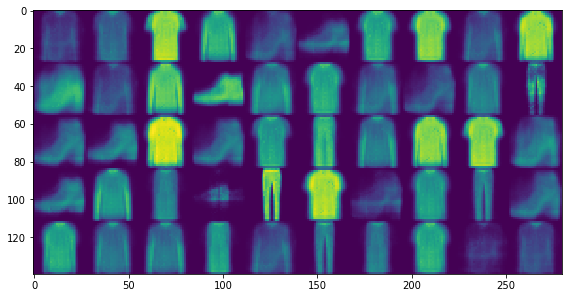

In [157]:
cols, rows = 10, 5

vae.eval()
seeds = torch.normal(0, 1, (rows * cols, 2)).to(DEVICE)
imgs = vae.decode(seeds).detach().cpu().numpy()
imgs = imgs.reshape(rows, cols, imgs.shape[1], imgs.shape[2])

imgs = np.split(imgs, rows)
imgs = np.concatenate(imgs, axis=2)[0]
imgs = np.split(imgs, cols)
imgs = np.concatenate(imgs, axis=2)[0]

fix, ax = plt.subplots(1, 1, figsize=(8, 10))
ax.imshow(imgs)
plt.tight_layout()

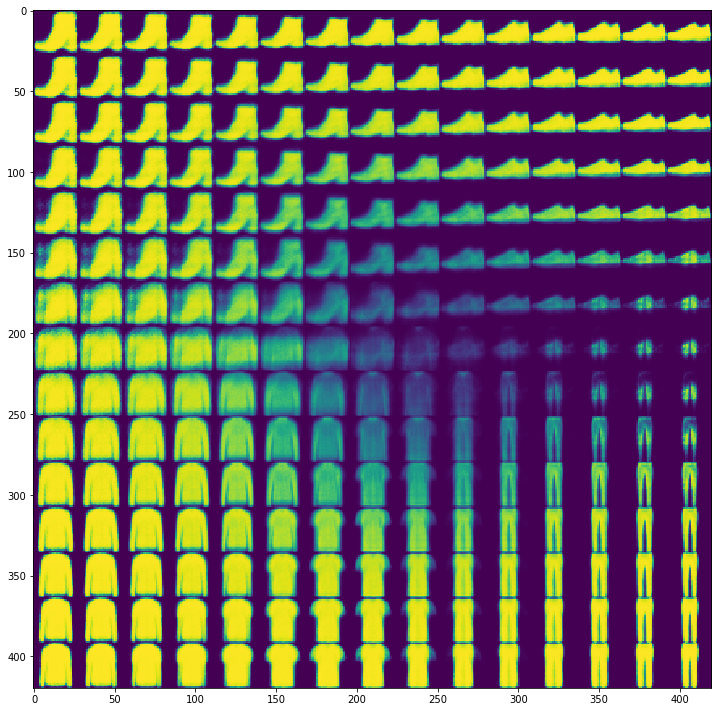

In [178]:
cols, rows = 15, 15

left = -5
right = 5

xx = torch.arange(left, right, (right - left) / cols)
yy = torch.arange(left, right, (right - left) / rows)
x, y = torch.meshgrid(xx, yy)
mesh = torch.stack((x, y), dim=2)

seeds = mesh.reshape(-1, 2).to(DEVICE)
imgs = vae.decode(seeds).detach().cpu().numpy()
imgs = imgs.reshape(rows, cols, imgs.shape[1], imgs.shape[2])

imgs = np.split(imgs, rows)
imgs = np.concatenate(imgs, axis=2)[0]
imgs = np.split(imgs, cols)
imgs = np.concatenate(imgs, axis=2)[0]

fix, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(imgs)
plt.tight_layout()

(448, 448)

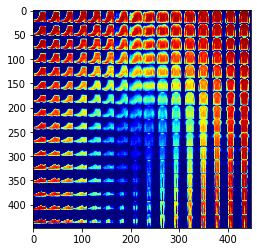

In [187]:
def render_frame():
    cols, rows = 16, 16

    left = -3.5
    right = 3.5

    xx = torch.arange(left, right, (right - left) / cols)
    yy = torch.arange(left, right, (right - left) / rows)
    x, y = torch.meshgrid(xx, yy)
    mesh = torch.stack((x, y), dim=2)

    seeds = mesh.reshape(-1, 2).to(DEVICE)
    imgs = vae.decode(seeds).detach().cpu().numpy()
    imgs = imgs.reshape(rows, cols, imgs.shape[1], imgs.shape[2])

    imgs = np.split(imgs, rows)
    imgs = np.concatenate(imgs, axis=2)[0]
    imgs = np.split(imgs, cols)
    imgs = np.concatenate(imgs, axis=2)[0]

    return (matplotlib.cm.jet(imgs)[...,:3] * 255).astype(np.uint8)


i = render_frame()
plt.imshow(i)
W, H, _ = i.shape
W, H

In [184]:
vae = VAE(X[0].shape, 2).to(DEVICE)

In [185]:
import cv2

name = './fashion_mnist_vae_training.mp4'

fourcc = cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(name, fourcc, 30, (H, W))

def make_video_frame(i):
    if i % 5 == 0:
        frame = render_frame()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame)

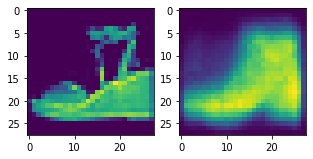

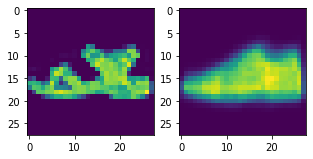

In [186]:
loader = mk_data_loader(bs=64)
history = optimize(
    model=vae,
    data=loader,
    epochs=2,
    lr=0.0001,
    on_it=make_video_frame
)

video.release()